# <font color='#42AAFF'>Содержание</font><a id='toc0_'></a>    
1. [<font color='#42AAFF'>Введение</font>](#toc1_)    
2. [<font color='#42AAFF'>Обзор данных</font>](#toc2_)    
2.1. [<font color='#42AAFF'>Вывод</font>](#toc2_1_)    
3. [<font color='#42AAFF'>Подготовка данных</font>](#toc3_)    
3.1. [<font color='#42AAFF'>Проверка правильности расчёта эффективности обогащения на обучающей выборке</font>](#toc3_1_)    
3.2. [<font color='#42AAFF'>Признаки в тестовой и тренирочных выборках</font>](#toc3_2_)    
3.3. [<font color='#42AAFF'>Предобработка данных</font>](#toc3_3_)    
3.4. [<font color='#42AAFF'>Выводы</font>](#toc3_4_)    
4. [<font color='#42AAFF'>Исследование данных</font>](#toc4_)    
4.1. [<font color='#42AAFF'>Концентрация металлов на различных этапах очистки</font>](#toc4_1_)    
4.2. [<font color='#42AAFF'>Сравнение размеров гранул сырья на обучающей и тестовой выборках</font>](#toc4_2_)    
4.3. [<font color='#42AAFF'>Cуммарная концентрация всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах</font>](#toc4_3_)    
4.4. [<font color='#42AAFF'>Выводы</font>](#toc4_4_)    
5. [<font color='#42AAFF'>Обучение моделей</font>](#toc5_)    
5.1. [<font color='#42AAFF'>Функция для вычисления итоговой sMAPE</font>](#toc5_1_)    
5.2. [<font color='#42AAFF'>Подготовка выборок для обучения</font>](#toc5_2_)    
5.3. [<font color='#42AAFF'>Стандартизация признаков</font>](#toc5_3_)    
5.4. [<font color='#42AAFF'>Исключение мультиколлинеарных признаков для оценки эффективности обогащения чернового концентрата</font>](#toc5_4_)    
5.5. [<font color='#42AAFF'>Исключение мультиколлинеарных признаков для оценки эффективности обогащения финального концентрата</font>](#toc5_5_)    
5.6. [<font color='#42AAFF'>Оптимизация модели для оценки эффективности обогащения чернового концентрата</font>](#toc5_6_)    
5.7. [<font color='#42AAFF'>Оптимизация модели для оценки эффективности обогащения финального концентрата</font>](#toc5_7_)    
5.8. [<font color='#42AAFF'>Выводы</font>](#toc5_8_)    
6. [<font color='#42AAFF'>Результаты оценок моделей на тестовой выборке</font>](#toc6_)    
7. [<font color='#42AAFF'>Общие выводы</font>](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[<font color='#42AAFF'>Введение</font>](#toc0_)

**Задачи**

Необходимо построить модель машинного обучения для компании, разрабатывающей решения для эффективной работы промышленных предприятий. Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды на основе данных с параметрами добычи и очистки. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Исходную задачу можно разбить на 2 этапа:
-	прогноз эффективность обогащения чернового концентрата rougher.output.recovery;
-	прогноз эффективность обогащения финального концентрата final.output.recovery.

**Описание данных**

Технологический процесс
-	Rougher feed — исходное сырье
-	Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    - Xanthate **— ксантогенат (промотер, или активатор флотации);
    - Sulphate — сульфат (на данном производстве сульфид натрия);
    - Depressant — депрессант (силикат натрия).
-   Rougher process (англ. «грубый процесс») — флотация
-	Rougher tails — отвальные хвосты
-	Float banks — флотационная установка
-	Cleaner process — очистка
-	Rougher Au — черновой концентрат золота
-	Final Au — финальный концентрат золота
Параметры этапов
-	air amount — объём воздуха
-	fluid levels — уровень жидкости
-	feed size — размер гранул сырья
-	feed rate — скорость подачи

Наименование признаков должно быть такое:

**[этап].[тип_параметра].[название_параметра]**

Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:
-	rougher — флотация
-	primary_cleaner — первичная очистка
-	secondary_cleaner — вторичная очистка
-	final — финальные характеристики

Возможные значения для блока [тип_параметра]:
-	input — параметры сырья
-	output — параметры продукта
-	state — параметры, характеризующие текущее состояние этапа
-	calculation — расчётные характеристики

# 2. <a id='toc2_'></a>[<font color='#42AAFF'>Обзор данных</font>](#toc0_)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn as skl
from joblib import dump, load
from scipy.interpolate import splrep, splev
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error, make_scorer, r2_score
from sklearn.linear_model import LinearRegression

In [2]:
train = pd.read_csv('datasets/gold_recovery_train_new.csv')
test = pd.read_csv('datasets/gold_recovery_test_new.csv')
full = pd.read_csv('datasets/gold_recovery_full_new.csv')

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', -1)

In [4]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [5]:
test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [6]:
train.head().T

,0,1,2,3,4
date,2016-01-15 00:00:00,2016-01-15 01:00:00,2016-01-15 02:00:00,2016-01-15 03:00:00,2016-01-15 04:00:00
final.output.concentrate_ag,6.055403,6.029369,6.055926,6.047977,6.148599
final.output.concentrate_pb,9.889648,9.968944,10.213995,9.977019,10.142511
final.output.concentrate_sol,5.507324,5.257781,5.383759,4.858634,4.939416
final.output.concentrate_au,42.19202,42.701629,42.657501,42.689819,42.774141
final.output.recovery,70.541216,69.266198,68.116445,68.347543,66.927016
final.output.tail_ag,10.411962,10.462676,10.507046,10.422762,10.360302
final.output.tail_pb,0.895447,0.927452,0.953716,0.883763,0.792826
final.output.tail_sol,16.904297,16.634514,16.208849,16.532835,16.525686
final.output.tail_au,2.143149,2.22493,2.257889,2.146849,2.055292


In [7]:
test.head().T

,0,1,2,3,4
date,2016-09-01 00:59:59,2016-09-01 01:59:59,2016-09-01 02:59:59,2016-09-01 03:59:59,2016-09-01 04:59:59
primary_cleaner.input.sulfate,210.800909,215.392455,215.259946,215.336236,199.099327
primary_cleaner.input.depressant,14.993118,14.987471,12.884934,12.006805,10.68253
primary_cleaner.input.feed_size,8.08,8.08,7.786667,7.64,7.53
primary_cleaner.input.xanthate,1.005021,0.990469,0.996043,0.863514,0.805575
primary_cleaner.state.floatbank8_a_air,1398.981301,1398.777912,1398.493666,1399.618111,1401.268123
primary_cleaner.state.floatbank8_a_level,-500.225577,-500.057435,-500.86836,-498.863574,-500.808305
primary_cleaner.state.floatbank8_b_air,1399.144926,1398.055362,1398.860436,1397.44012,1398.128818
primary_cleaner.state.floatbank8_b_level,-499.919735,-499.778182,-499.764529,-499.211024,-499.504543
primary_cleaner.state.floatbank8_c_air,1400.102998,1396.151033,1398.075709,1400.129303,1402.172226


In [8]:
train.describe().applymap('{:.1f}'.format).T

,count,mean,std,min,25%,50%,75%,max
final.output.concentrate_ag,14148.0,5.1,1.4,0.0,4.2,5.0,5.9,16.0
final.output.concentrate_pb,14148.0,10.1,1.7,0.0,9.3,10.3,11.2,17.0
final.output.concentrate_sol,13938.0,9.2,2.8,0.0,7.5,8.8,10.5,18.1
final.output.concentrate_au,14149.0,44.0,4.9,0.0,43.3,44.9,46.2,52.8
final.output.recovery,14149.0,66.5,10.3,0.0,62.5,67.4,72.3,100.0
final.output.tail_ag,14149.0,9.6,2.3,0.0,8.0,9.5,11.0,19.6
final.output.tail_pb,14049.0,2.6,1.0,0.0,1.9,2.6,3.2,5.6
final.output.tail_sol,14144.0,10.5,3.0,0.0,8.8,10.5,11.9,22.3
final.output.tail_au,14149.0,2.9,0.9,0.0,2.4,2.9,3.4,8.2
primary_cleaner.input.sulfate,14129.0,133.3,39.4,0.0,107.0,133.0,159.8,250.1


In [9]:
test.describe().applymap('{:.1f}'.format).T

,count,mean,std,min,25%,50%,75%,max
primary_cleaner.input.sulfate,5286.0,174.8,43.0,2.6,147.1,177.8,208.1,266.0
primary_cleaner.input.depressant,5285.0,8.7,3.1,0.0,6.5,8.1,10.0,40.0
primary_cleaner.input.feed_size,5290.0,7.3,0.6,5.7,6.9,7.2,7.6,15.5
primary_cleaner.input.xanthate,5286.0,1.4,0.6,0.0,0.9,1.2,1.8,4.1
primary_cleaner.state.floatbank8_a_air,5290.0,1539.5,116.8,0.0,1498.9,1585.1,1602.1,2103.1
primary_cleaner.state.floatbank8_a_level,5290.0,-497.7,20.0,-795.3,-500.4,-500.0,-499.6,-57.2
primary_cleaner.state.floatbank8_b_air,5290.0,1545.2,122.2,0.0,1499.0,1595.6,1602.3,1813.1
primary_cleaner.state.floatbank8_b_level,5290.0,-500.3,33.0,-800.0,-500.7,-500.0,-499.3,-142.5
primary_cleaner.state.floatbank8_c_air,5290.0,1527.3,122.5,0.0,1473.2,1549.6,1601.1,1715.1
primary_cleaner.state.floatbank8_c_level,5290.0,-498.3,22.0,-800.0,-501.0,-500.0,-499.0,-150.9


## 2.1. <a id='toc2_1_'></a>[<font color='#42AAFF'>Вывод</font>](#toc0_)
1. Для анализа представлены 3 таблицы -полная, обучающая (87 столбцов) и тестовая (53 столбца).
2. Строки в таблицах соответствуют времени обработка, по сути все столбцы признаков являются числовыми временными рядами.
3. Все столбцы имеют соответствующие типы данных, кроме столбца `date`, который необходимо преобразовать к формату времени.
4. В данных есть пропуски.
5. Некоторые признаки имеют скошенный вид (медиана существенно отличается от среднего), также для некоторых признаков характерны выбросы.

# 3. <a id='toc3_'></a>[<font color='#42AAFF'>Подготовка данных</font>](#toc0_)

## 3.1. <a id='toc3_1_'></a>[<font color='#42AAFF'>Проверка правильности расчёта эффективности обогащения на обучающей выборке</font>](#toc0_)

Выполним расчёт эффективности обогащения на этапе флотации по формуле:

$Recovery = \frac{C*(F-T)}{F*(C-T)}$,

где
* C — доля золота в концентрате после флотации/очистки
* F — доля золота в сырье/концентрате до флотации/очистки
* T — доля золота в отвальных хвостах после флотации/очистки.

In [10]:
cau = train['rougher.output.concentrate_au']
fau = train['rougher.input.feed_au']
tau = train['rougher.output.tail_au']

train['rougher.output.recovery_est'] = cau * (fau - tau) / fau / (cau - tau) * 100

In [11]:
print(f'MAE эффективности обогащения по имеющимся данным и по формуле {mean_absolute_error(train["rougher.output.recovery"], train["rougher.output.recovery_est"]):0.2e}')

MAE эффективности обогащения по имеющимся данным и по формуле 1.07e-14


Полученная MAE крайне мала, таким образом значения признака и расчёты, выполненные в соответствии с формулой, совпадают.

## 3.2. <a id='toc3_2_'></a>[<font color='#42AAFF'>Признаки в тестовой и тренирочных выборках</font>](#toc0_)

В тестовой выборке отсутствуют целевые признаки, найдем их в полной по дате и добавим столбцы в тестовую:

In [12]:
test = pd.merge(full[['date','rougher.output.recovery','final.output.recovery']],test, how='inner', on=['date'])
test.shape

(5290, 55)

Выделим признаки тренировочной выборки, которых нет в тестовой.

In [13]:
test_features = list(test.columns)
train_features = list(train.columns)
features_diff = [item for item in train_features if item not in test_features]

Рассмотрим признаки этапа флотации, которых нет в тестовой выборке:

In [14]:
features_rougher_diff = [item for item in features_diff if 'rougher' in item]
print(features_rougher_diff)
print(len(features_rougher_diff)-1)

['rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', 'rougher.output.tail_ag', 'rougher.output.tail_pb', 'rougher.output.tail_sol', 'rougher.output.tail_au', 'rougher.output.recovery_est']
12


Таким образом, в тестовой выборке полностью отсутствуют расчётные характеристики (calculation) и характеристики продукта (output), включае данные по хвостам. Всего таких признаков 12.

Рассмотрим признаки этапа первичной очистки, которых нет в тестовой выборке:

In [15]:
features_primary_diff = [item for item in features_diff if 'primary' in item]
print(features_primary_diff)
print(len(features_primary_diff))

['primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au']
8


Таким образом, в тестовой выборке полностью отсутствуют характеристики продукта (output). Всего таких признаков 8.

Рассмотрим признаки этапа воричной очистки, которых нет в тестовой выборке:

In [16]:
features_secondary_diff = [item for item in features_diff if 'secondary' in item]
print(features_secondary_diff)
print(len(features_secondary_diff))

['secondary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_pb', 'secondary_cleaner.output.tail_sol', 'secondary_cleaner.output.tail_au']
4


Таким образом, в тестовой выборке полностью отсутствуют характеристики продукта (output). Отметим, что в характеристики продукта вторичной очистки входят только данные по хвостам. Всего таких признаков 4.

Рассмотрим финальные характеристики, которых нет в тестовой выборке:

In [17]:
features_final_diff = [item for item in features_diff if 'final' in item]
print(features_final_diff)
print(len(features_final_diff))

['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au', 'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol', 'final.output.tail_au']
8


Таким образом, в тестовой выборке полностью отсутствуют финальные характеристики продукта (output). Всего таких признаков 8.

## 3.3. <a id='toc3_3_'></a>[<font color='#42AAFF'>Предобработка данных</font>](#toc0_)

Убедимся в отсутствии дубликатов:

In [18]:
print(train.duplicated().sum(), test.duplicated().sum())

0 0


Явных дубликатов не обнаружили

In [19]:
print(
    f'Доля дубликатов по дате \n',
    f'тренировочная выборка: {train["date"].duplicated().sum()/len(train):0.1%} \n',
    f'тестовая выборка: {test["date"].duplicated().sum()/len(test):0.1%} \n',    
)   

Доля дубликатов по дате 
 тренировочная выборка: 0.0% 
 тестовая выборка: 0.0% 



Определим есть ли пропуски:

In [20]:
print(
    f'Количество пропусков \n',
    f'тренировочная выборка {train.isna().sum().sum():0.0f} \n', 
    f'тренировочная выборка только столбцы из тестовой {train[test.columns].isna().sum().sum():0.0f} \n', 
    f'тестовая выборка {test.isna().sum().sum():0.0f}'
    )

Количество пропусков 
 тренировочная выборка 4100 
 тренировочная выборка только столбцы из тестовой 1705 
 тестовая выборка 90


В тестовой выборке пропусков немного, поэтому строки с ними просто удалим:

In [21]:
test.dropna(inplace=True)
print(test.isna().sum().sum())

0


В тренировочной выборке будем рассматривать только пропуска в столбцах с признаками, имеющимися в тестовой выборке (то есть независимыми или целевыми), необходимыми для дальнейшего обучения модели. Доля строк c пропусками составляет ~ 12%, такой объем данных не хотелось бы потерять, попробуем их заполнить. Рассмотрим признаки, в которых пропусков больше 50, таких столбцов всего 7, при этом охват пропусков ~ 90%:

In [22]:
print(train[test.columns].isna().sum()[train[test.columns].isna().sum()>50])
print(f'Доля охваченных пропусков {(train[test.columns].isna().sum()[train[test.columns].isna().sum()>50].sum()/train[test.columns].isna().sum().sum()):0.0%}')

primary_cleaner.input.xanthate              100
rougher.input.feed_pb                       100
rougher.input.feed_size                     144
rougher.input.feed_sol                       78
rougher.input.floatbank11_xanthate          428
rougher.state.floatbank10_e_air             436
secondary_cleaner.state.floatbank2_a_air    217
dtype: int64
Доля охваченных пропусков 88%


Изменим тип данных в столбце date и отсортируем строки в порядке возрастания времени:

In [23]:
train['date'] = train['date'].astype('datetime64')
tmin = train['date'].min()
train['date'] = train['date'] - tmin
train['date'] =train['date'].dt.total_seconds()/3600/24
train = train.sort_values(by=['date'], ascending=True)

Рассмотрим временную зависимость для признака с большим количеством пропусков, например для 'rougher.input.floatbank11_xanthate'. Пропуски обозначим вертикальными красными линиями.

In [24]:
#строим сплайн аппроксимацию
x1 = np.array(train[~train['rougher.input.floatbank11_xanthate'].isna()]['date'])
y1 = np.array(train[~train['rougher.input.floatbank11_xanthate'].isna()]['rougher.input.floatbank11_xanthate'])
n_interior_knots = 100
qs = np.linspace(0, 1, n_interior_knots+2)[1:-1]
knots = np.quantile(x1, qs)
tck = splrep(x1, y1, t=knots, k=3)
y1_smooth = splev(x1, tck)

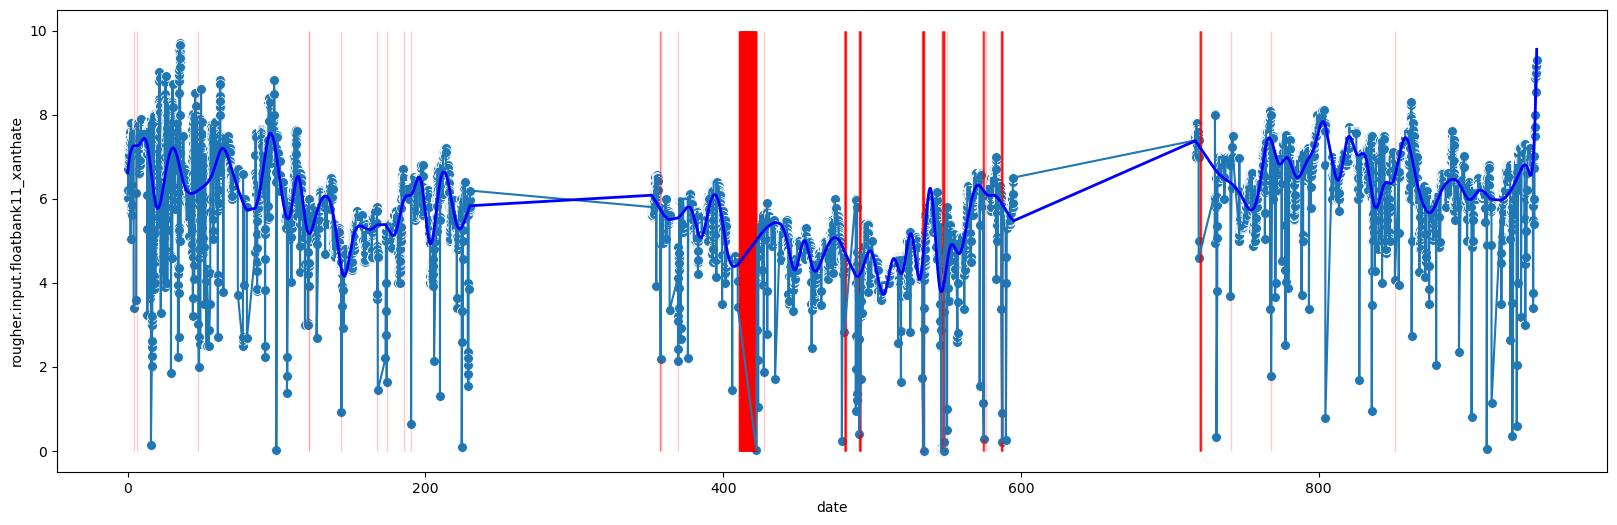

In [25]:
fig, axs = plt.subplots(figsize=(20,6))
sns.lineplot(data=train,x='date',y='rougher.input.floatbank11_xanthate',ax=axs)
sns.scatterplot(data=train,x='date',y='rougher.input.floatbank11_xanthate',marker='o',s=50,ax=axs)
for date in train[train['rougher.input.floatbank11_xanthate'].isna()]['date']:
    sns.lineplot(x=[date, date],y=[0, 10],color ='r',ax=axs)
sns.lineplot(x=x1,y=y1_smooth,color ='b',lw=2,ax=axs)
plt.show()

1. Временная зависимость имеет высокочастотные выбросы (в 1-2 точки) большой амплитуды, что, вообще говоря, не похоже на реалистичные показатели техпроцесса, и существенно более низкоамплитудную и низкочастотную компоненту.
2. С моей точки зрения в такой ситуации лучше или не заполнять пропуски, или заполнять их с помощью аппроксимации данных, например, кубическим B сплайном (синий жирный), перед аппроксимацией можно также отфильтровать высокочастотную компоненту, что улучшит качество аппроксимации.

Убедимся, что сплайн достаточно хорошо описывает зависимость в области пропусков.

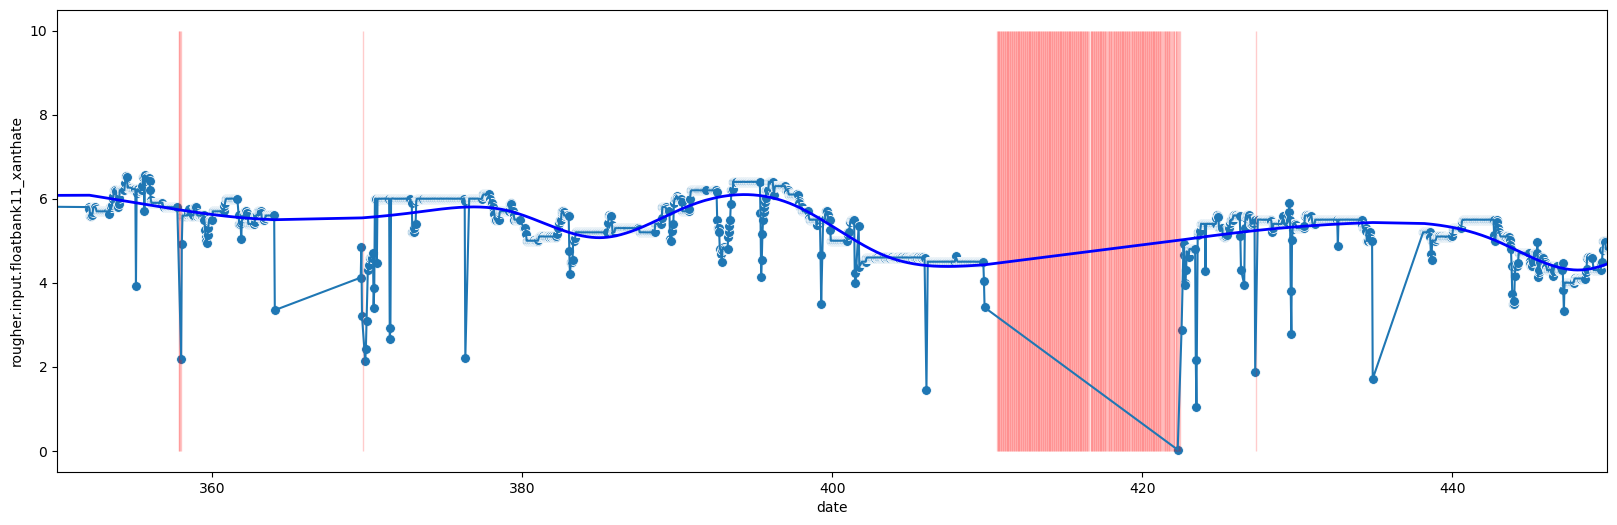

In [26]:
fig, axs = plt.subplots(figsize=(20,6))
sns.lineplot(data=train,x='date',y='rougher.input.floatbank11_xanthate',ax=axs)
sns.scatterplot(data=train,x='date',y='rougher.input.floatbank11_xanthate',marker='o',s=50,ax=axs)
for date in train[train['rougher.input.floatbank11_xanthate'].isna()]['date']:
    sns.lineplot(x=[date, date],y=[0, 10],color ='r',ax=axs)
sns.lineplot(x=x1,y=y1_smooth,color ='b',lw=2,ax=axs)
axs.set(xlim=(350,450)) 
plt.show()

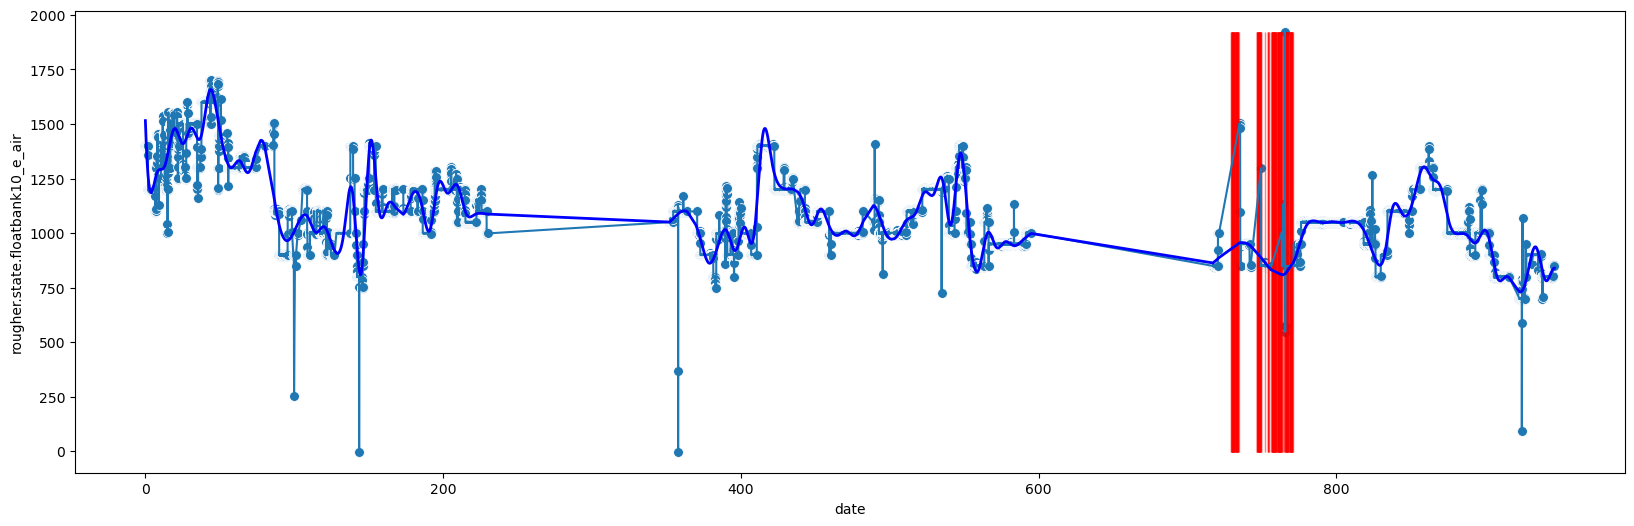

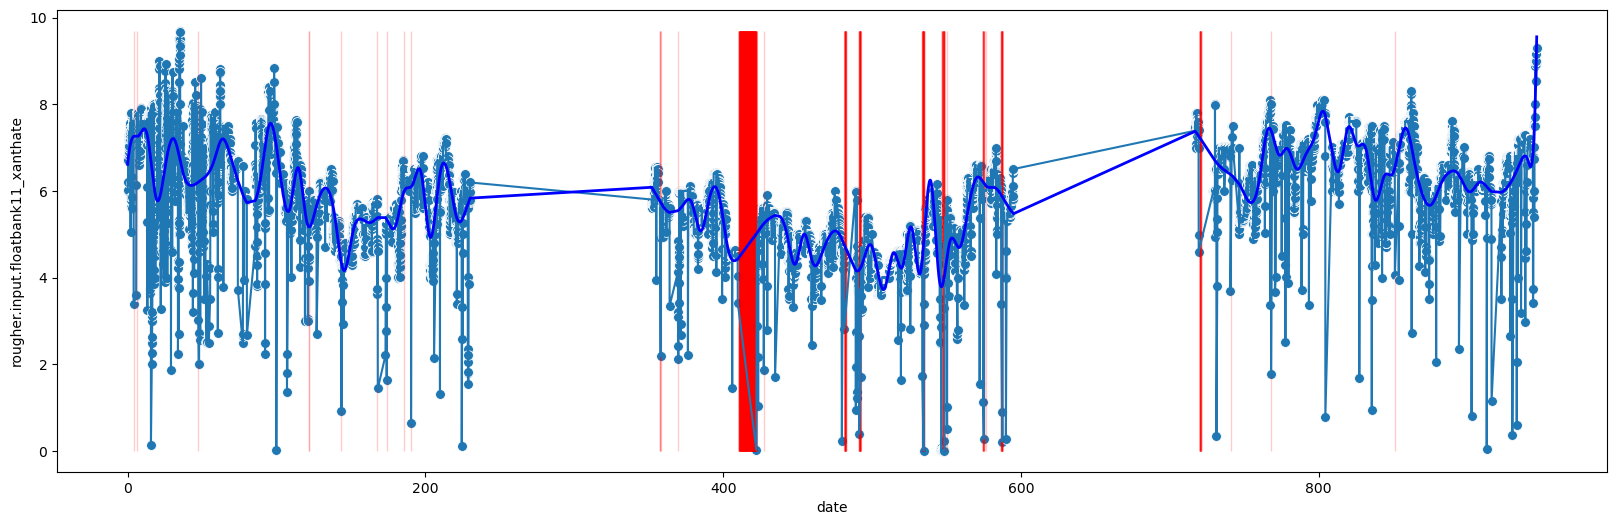

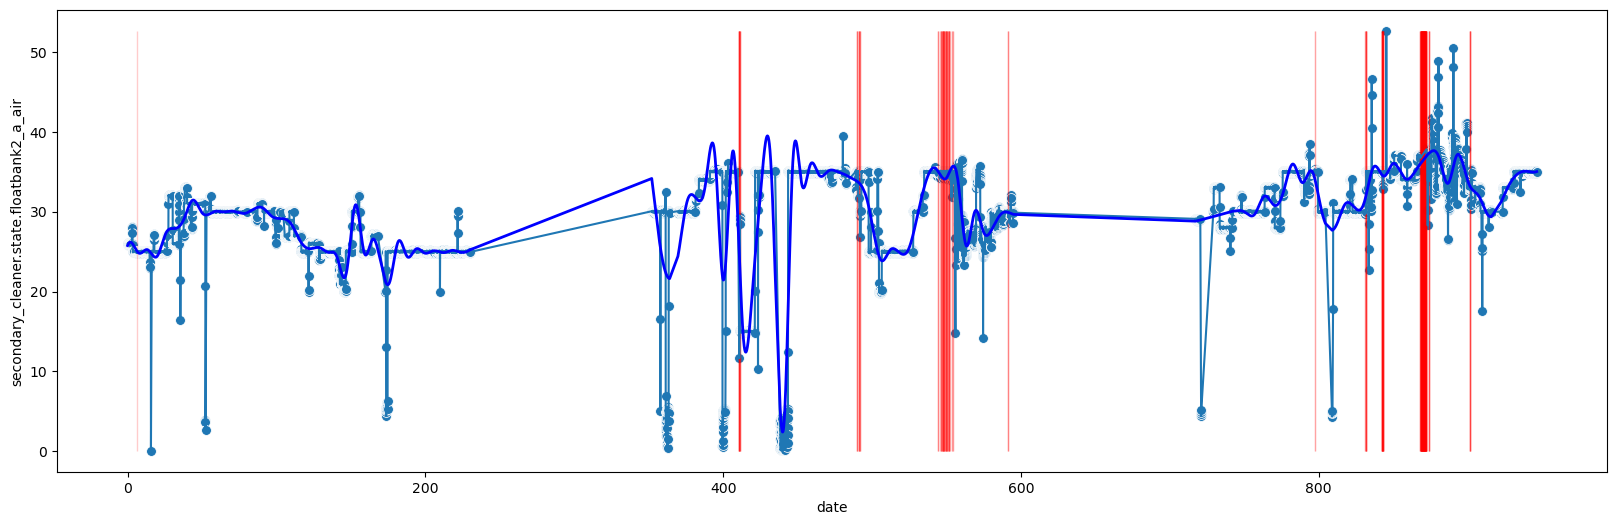

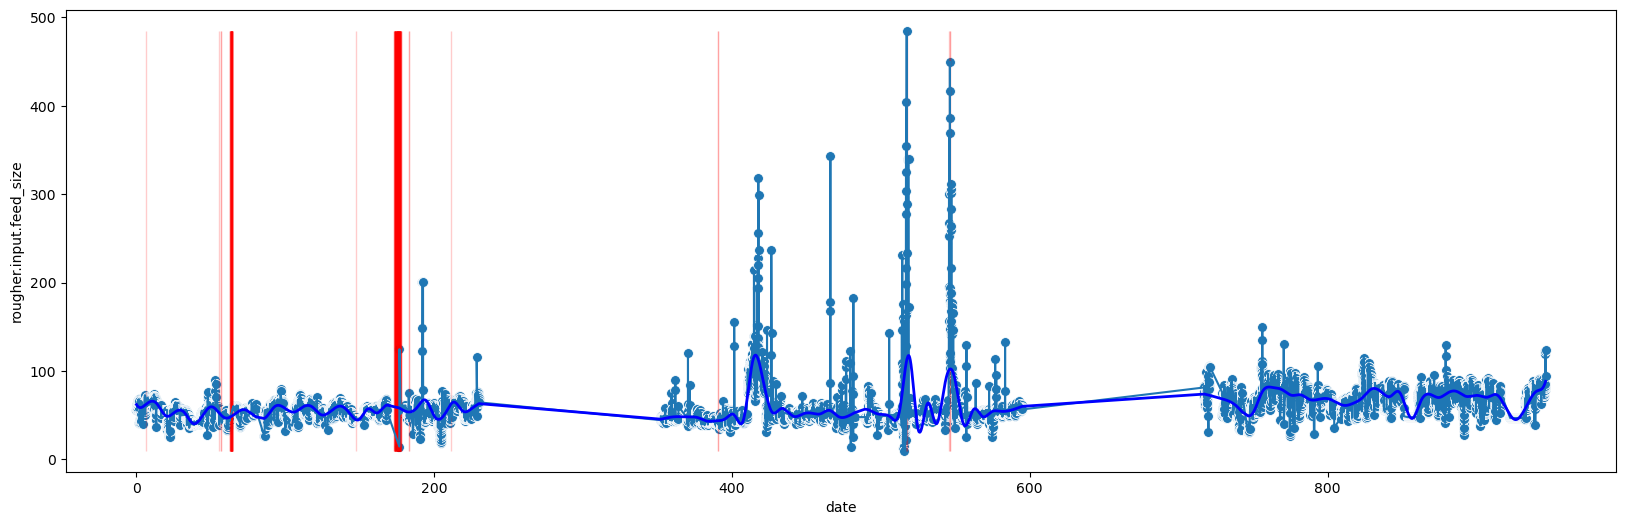

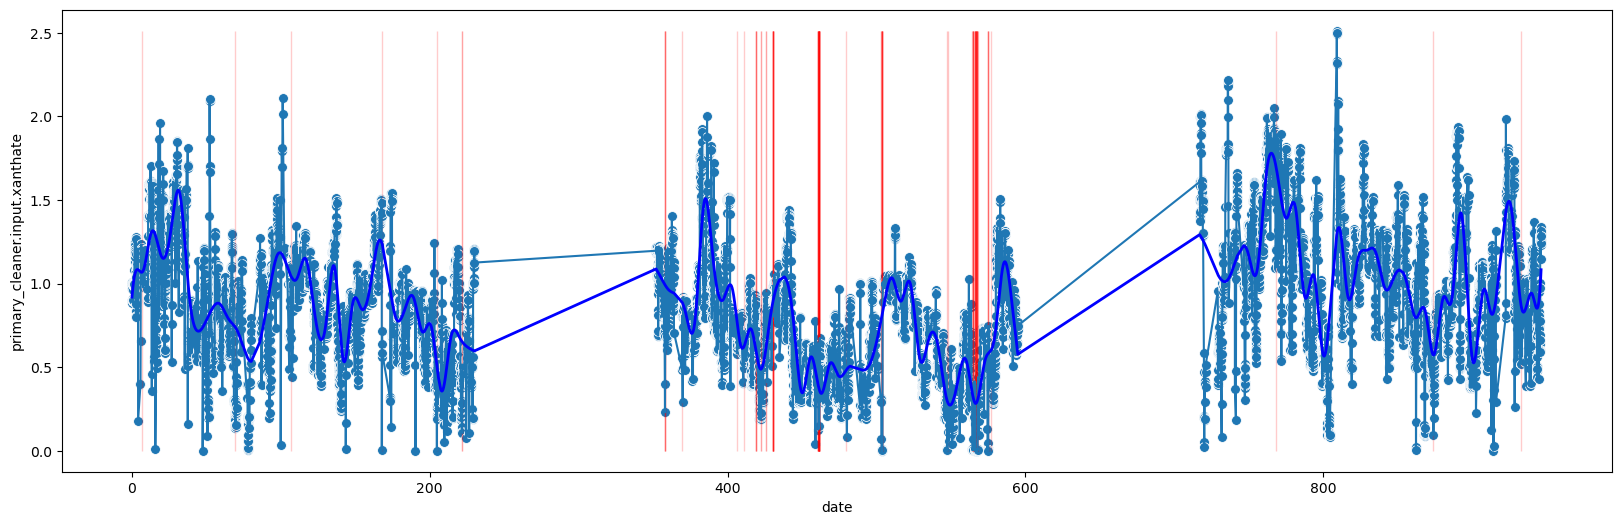

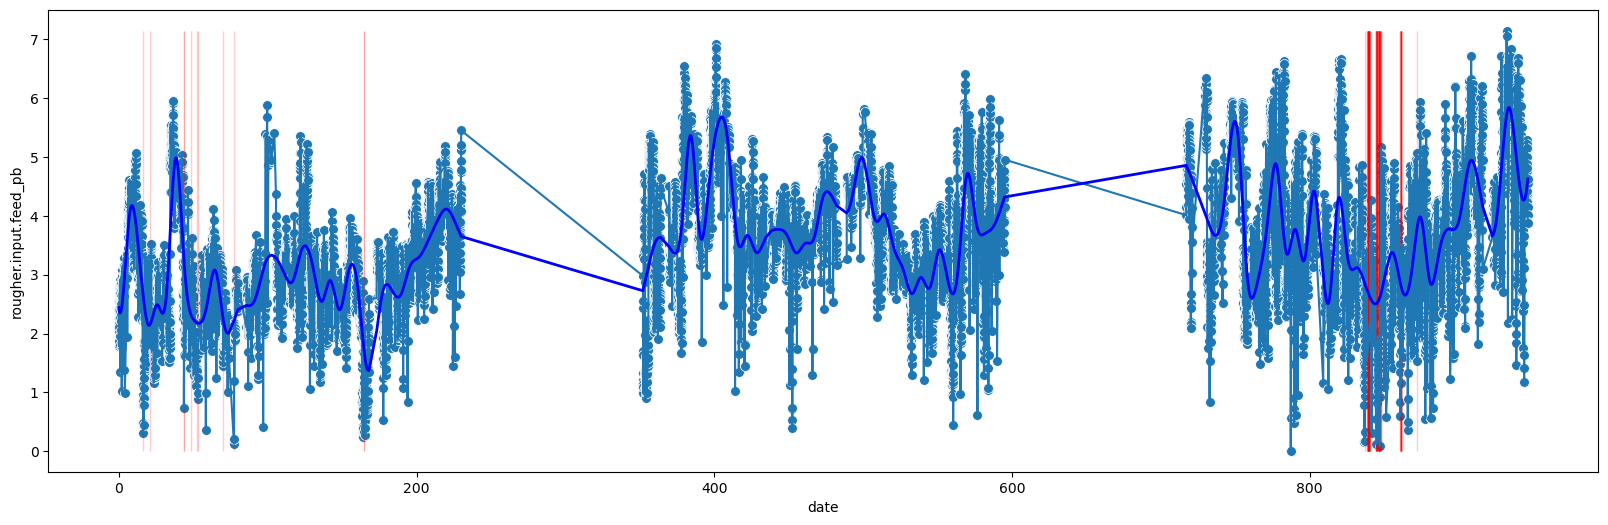

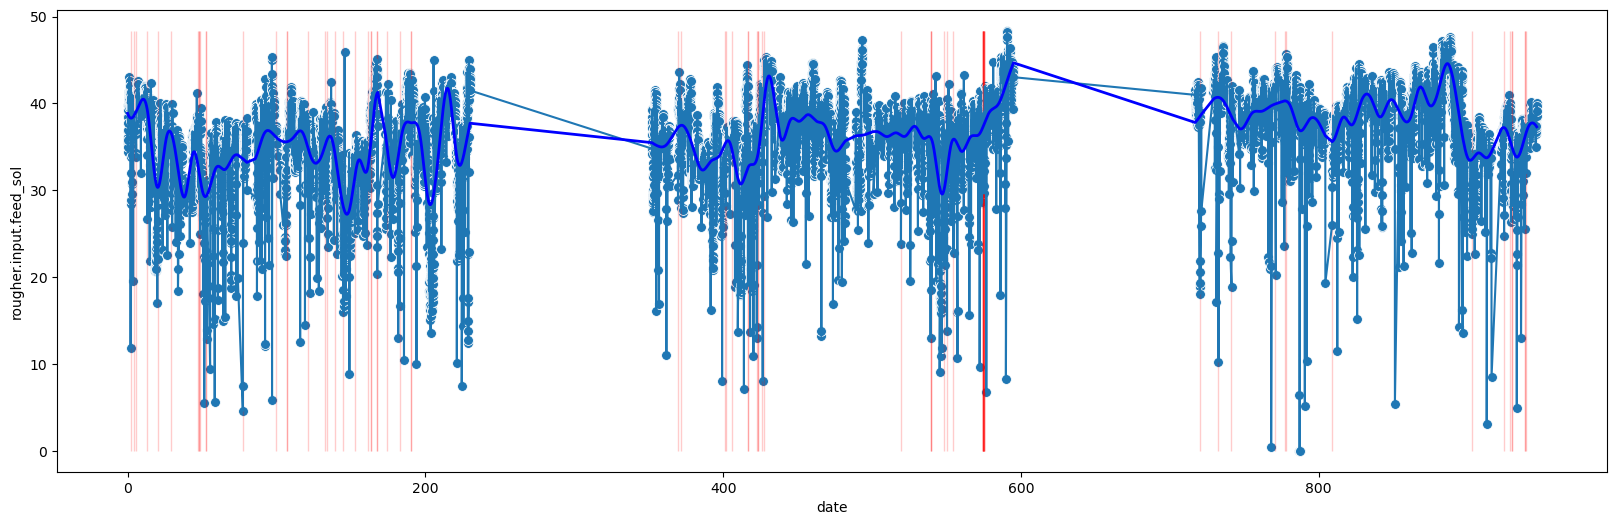

In [27]:
#создаем список признаков для аппроксимации
cols_list = train[test.columns].isna().sum()[train[test.columns].isna().sum()>50].sort_values(ascending=False).index

for item in cols_list:
    #строим сплайн аппроксимацию
    x1 = np.array(train[~train[item].isna()]['date'])
    y1 = np.array(train[~train[item].isna()][item])
    n_interior_knots = 100
    qs = np.linspace(0, 1, n_interior_knots+2)[1:-1]
    knots = np.quantile(x1, qs)
    tck = splrep(x1, y1, t=knots, k=3)
    y1_smooth = splev(x1, tck)
    
    #строим графики
    fig, axs = plt.subplots(figsize=(20,6))
    sns.lineplot(data=train,x='date',y=item,ax=axs)
    sns.scatterplot(data=train,x='date',y=item,marker='o',s=50,ax=axs)
    for date in train[train[item].isna()]['date']:
        sns.lineplot(x=[date, date],y=[train[item].min(), train[item].max()],color ='r',ax=axs)
    sns.lineplot(x=x1,y=y1_smooth,color ='b',lw=2,ax=axs)
    plt.show()


    #заполняем пропуски
    ind = train[train[item].isna()].index
    train.loc[ind,item] = splev(train.loc[ind,'date'], tck)

In [28]:
print(f'Кол-во оставшихся пропусков в тренировочной выборке для столбцов из тестовой {train[test.columns].isna().sum().sum():0.0f}\n' 
    f'Кол-во пропусков в целевых признаках тренировочной выборки \n'
    f'{train[["rougher.output.recovery","final.output.recovery"]].isna().sum()}') 

Кол-во оставшихся пропусков в тренировочной выборке для столбцов из тестовой 202
Кол-во пропусков в целевых признаках тренировочной выборки 
rougher.output.recovery    0
final.output.recovery      0
dtype: int64


Оставшиеся пропуски в обучающей выборке в интересующих признаках удалим:

In [29]:
train.dropna(subset=test.columns,inplace=True)
print(train.shape)

(14038, 88)


Рассмотрим целевые признаки:

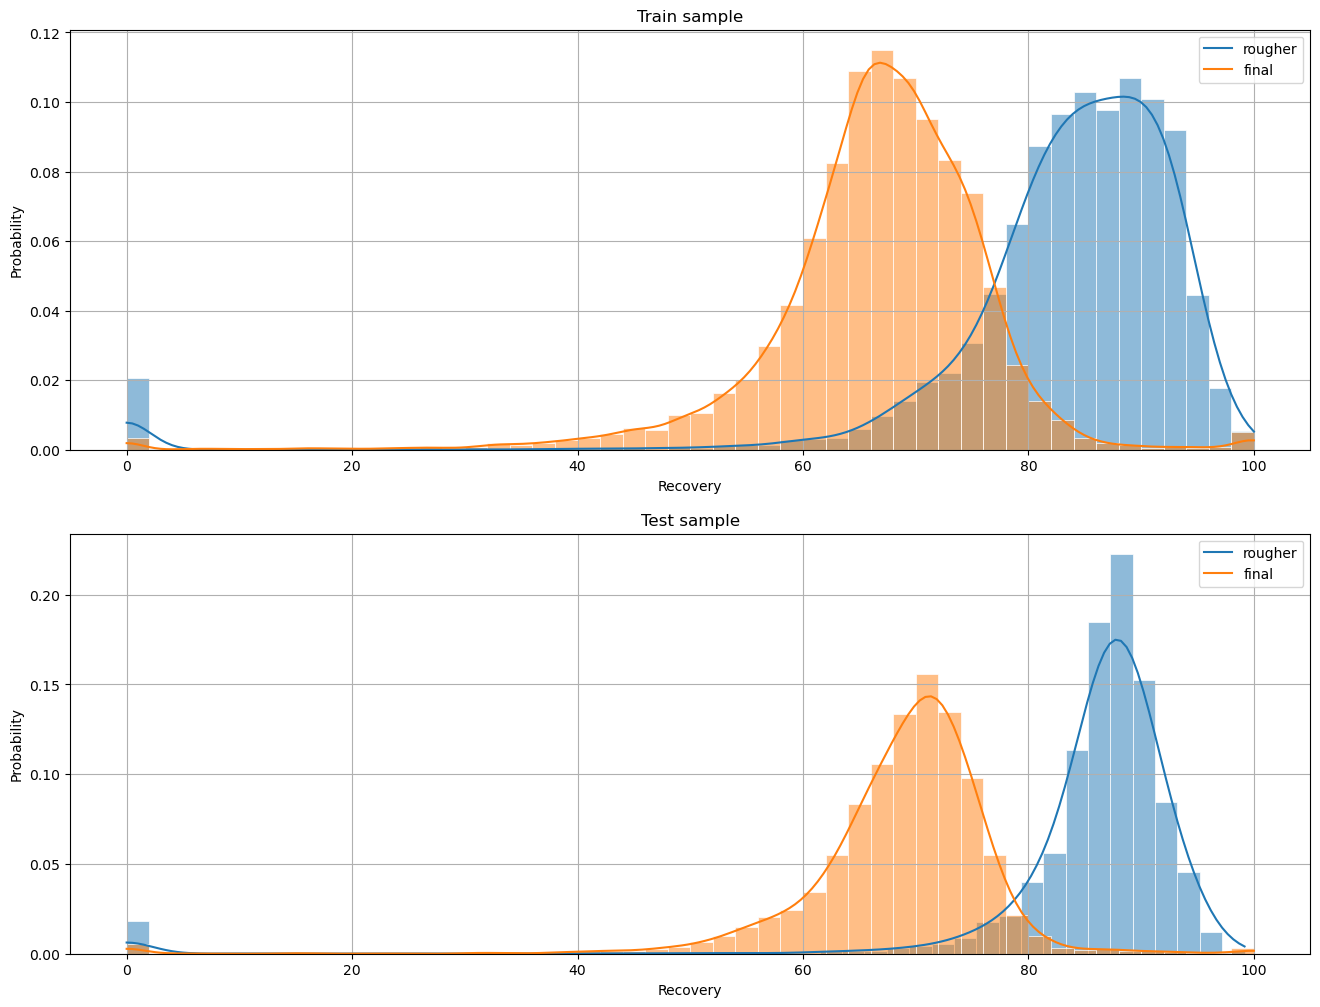

In [30]:
fig, axs = plt.subplots(nrows=2, figsize=(16,12))
sns.histplot(train['rougher.output.recovery'], bins=50, linewidth=0.5,color=sns.color_palette()[0], edgecolor="white",stat='probability',kde=True,ax=axs[0])
sns.histplot(train['final.output.recovery'], bins=50, linewidth=0.5,color=sns.color_palette()[1], edgecolor="white",stat='probability',kde=True,ax=axs[0])
axs[0].grid(True)
axs[0].legend(['rougher', 'final'])  
axs[0].set(xlabel='Recovery',title='Train sample')  

sns.histplot(test['rougher.output.recovery'], bins=50, linewidth=0.5,color=sns.color_palette()[0], edgecolor="white",stat='probability',kde=True,ax=axs[1])
sns.histplot(test['final.output.recovery'], bins=50, linewidth=0.5,color=sns.color_palette()[1], edgecolor="white",stat='probability',kde=True,ax=axs[1])
axs[1].grid(True)
axs[1].legend(['rougher', 'final'])  
axs[1].set(xlabel='Recovery',title='Test sample')  

plt.show()

Удалим значения recovery равные 0, так как это очевидные выбросы.

In [31]:
train = train[(train['rougher.output.recovery']!=0)&(train['final.output.recovery']!=0)]
#test = test[(test['rougher.output.recovery']!=0)&(test['final.output.recovery']!=0)]

## 3.4. <a id='toc3_4_'></a>[<font color='#42AAFF'>Выводы</font>](#toc0_)

1. Проверили правильности расчёта эффективности обогащения на обучающей выборке по имеющимся данным, получили MAE 1e-14, таким образом расчёты выполнены корректно.
2. Сравнили столбцы в обучающей и тестовой выборках, в тестовой выборке отсутствуют расчётные признаки (calculation) и характеристики продукта (output), включае данные по концентрату и хвостам.  
3. Явных дубликатов в данных не обнаружили.
4. В тестовой выборке доля пропусков невелика (90), поэтому строки с ними просто удалили.
5. В тренировочной выборке количество пропусков велико - 4100, при этом в необходимых для обучения признаках ~ 1700. Так как процесс очистки во времени непрерывный, то соседние по времени точки близки по своим значениям. Для заполнения пропусков в признаках, необходимых для обучения, применили аппроксимирующий сплайн.
6. В целевых показателях тренировочной выборки убрали выбросы равные 0.

# 4. <a id='toc4_'></a>[<font color='#42AAFF'>Исследование данных</font>](#toc0_)

## 4.1. <a id='toc4_1_'></a>[<font color='#42AAFF'>Концентрация металлов на различных этапах очистки</font>](#toc0_)

In [32]:
#сформируем сводную таблицу для построения боксплотов
concentration = pd.DataFrame(columns=['concentration', 'material', 'stage', 'type'])
material = ['ag', 'au', 'pb', 'sol']
stage = ['rougher', 'primary', 'secondary']
frtype = ['tail', 'concentrate']
#добавляем данные по этапу input
lst_col0 = list(train.columns)
lst_col0 = [item for item in lst_col0 if 'input'  in item]
for m in material:
    lst_col1 = [item for item in lst_col0 if m in item]
    item_df = []
    item_df = pd.DataFrame(columns=['concentration','material','stage','type'])
    item_df['concentration'] = train[lst_col1]
    item_df['material'] = item_df['material'].fillna(m)
    item_df['stage'] = item_df['stage'].fillna('input')
    item_df['type'] = item_df['type'].fillna('concentrate') 
    concentration = pd.concat([concentration, item_df])  
#добавляем в сводную таблицу данные по этапам очистки
lst_col0 = list(train.columns)
lst_col0 = [item for item in lst_col0 if 'output' in item]
for m in material:        
    lst_col1 = [item for item in lst_col0 if m in item]
    for s in stage:
        lst_col2 = [item for item in lst_col1 if s in item]
        for t in frtype:
            lst_col3 = [item for item in lst_col2 if t in item]
            if lst_col3 != []:
                #print(lst_col3)
                item_df = []
                item_df = pd.DataFrame(columns=['concentration','material','stage','type'])
                item_df['concentration'] = train[lst_col3]
                item_df['material'] = item_df['material'].fillna(m)
                item_df['stage'] = item_df['stage'].fillna(s)
                item_df['type'] = item_df['type'].fillna(t)
                concentration = pd.concat([concentration, item_df])  
#добавляем данные по этапу final
lst_col0 = list(train.columns)
lst_col0 = [item for item in lst_col0 if 'final'  in item]
for m in material:
    lst_col1 = [item for item in lst_col0 if m in item]
    for t in frtype:
        lst_col2 = [item for item in lst_col1 if t in item]
        #print(lst_col2)
        item_df = []
        item_df = pd.DataFrame(columns=['concentration','material','stage','type'])
        item_df['concentration'] = train[lst_col2]
        item_df['material'] = item_df['material'].fillna(m)
        item_df['stage'] = item_df['stage'].fillna('final')
        item_df['type'] = item_df['type'].fillna(t) 
        concentration = pd.concat([concentration, item_df])

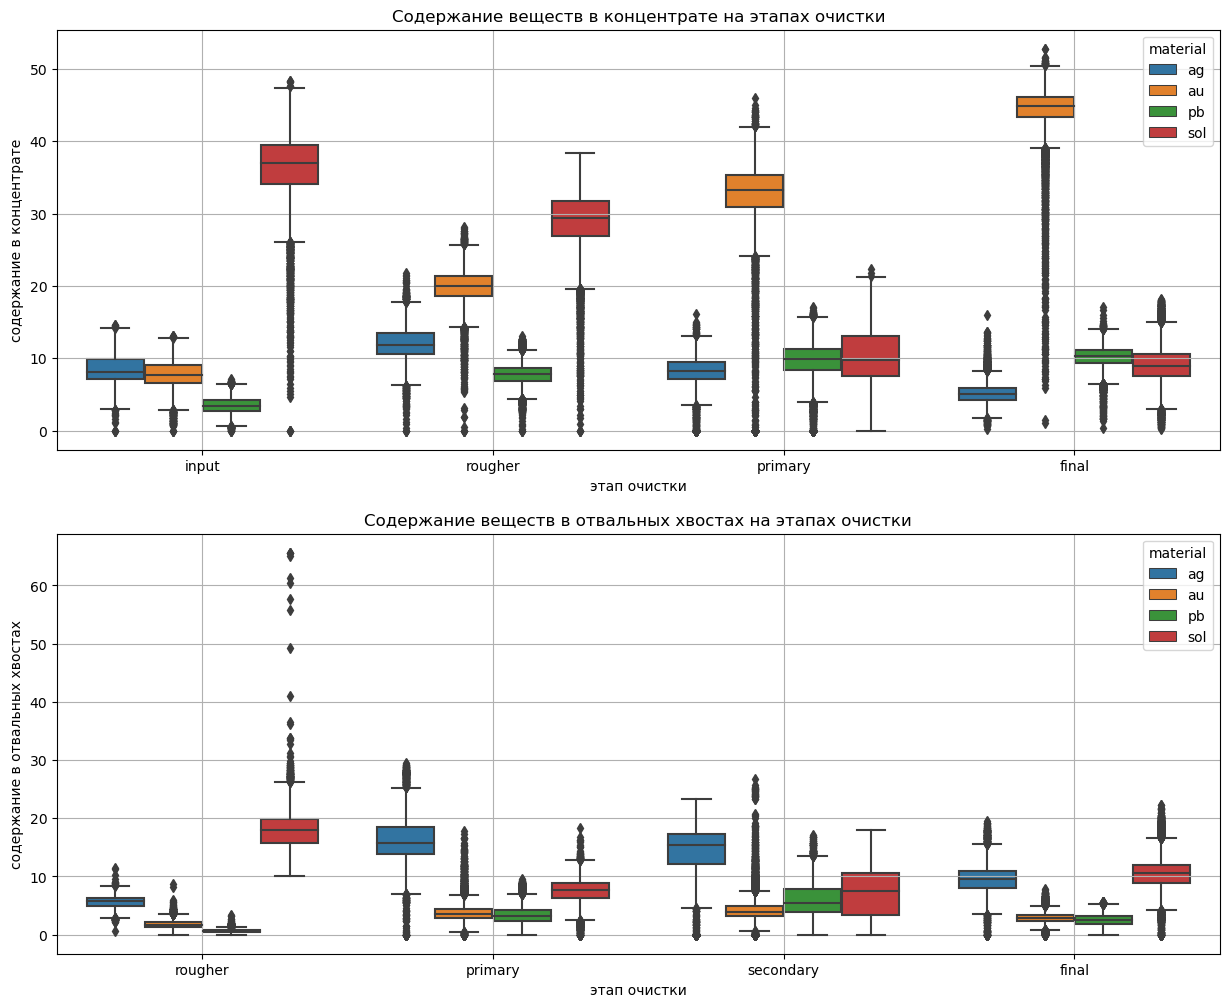

In [33]:
fig, axs = plt.subplots(nrows=2,figsize=(15,12))

#sns.boxplot(data=concentration.query('("sol" not in material)&("concentrate" in type)'), x='stage', y='concentration',hue = 'material',ax=axs[0])
sns.boxplot(data=concentration.query('"concentrate" in type'), x='stage', y='concentration',hue = 'material',ax=axs[0])
axs[0].set(xlabel='этап очистки',
       ylabel='содержание в концентрате',      
       title='Содержание веществ в концентрате на этапах очистки'       
       )
axs[0].grid(True)

#sns.boxplot(data=concentration.query('("sol" not in material)&("tail" in type)'), x='stage', y='concentration',hue = 'material',ax=axs[1])
sns.boxplot(data=concentration.query('"tail" in type'), x='stage', y='concentration',hue = 'material',ax=axs[1])
axs[1].set(xlabel='этап очистки',
       ylabel='содержание в отвальных хвостах',      
       title='Содержание веществ в отвальных хвостах на этапах очистки'       
       )
axs[1].grid(True)

plt.show()

По содержанию металлов на разных этапах очистки можно сделать следующие выводы:

1. Доля золота (Au) в концентрате растёт равномерно по этапам очистки в среднем на 10-15%. При этом межквартильный размах доли золота довольно мал и не превышает 3-4%. Таким образом, эффект влияния очистки на долю золота в концетрате хорошо выражен. Доля золота в финальном концетрате в среднем достигает 45%.
2. Доля серебра (Ag) в концентрате ведёт себя немонотонно, но в финальном концетрате доля серебра ниже, чем в сырье.
3. Доля свинца (Pb) в концентрате монотонно растёт, вероятно, исключительно за счёт уменьшения доли других компонентов.
4. Доля sol в концентрате монотонно падает, наиболее сильно падение наблюдается после первичной очистки, вторичная очистка практически не изменяет содержание sol, но снижает разброс.
4. Доли металлов в финальных хвостах являются чем-то усредненным по всем этапам очистки.
5. По долям металлов в хвостах видно, что грубая очистка принципиально отличается от первичной и вторичной очистки, последние очень близки по содержанию металлов в хвостах, доля которых в хвостах в разы выше, чем при грубой.

## 4.2. <a id='toc4_2_'></a>[<font color='#42AAFF'>Сравнение размеров гранул сырья на обучающей и тестовой выборках</font>](#toc0_)

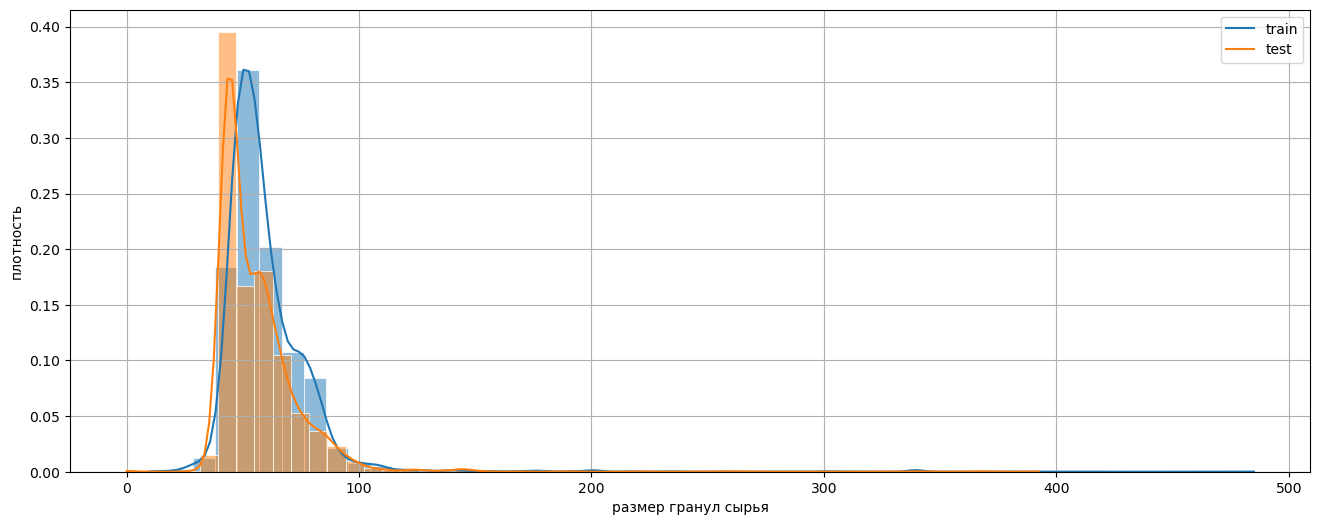

In [34]:
fig, axs = plt.subplots(figsize=(16,6))
h1 = sns.histplot(x=train['rougher.input.feed_size'], bins=50, linewidth=0.5,color=sns.color_palette()[0], edgecolor="white",stat='probability',kde=True,ax=axs)
h2 = sns.histplot(x=test['rougher.input.feed_size'], bins=50, linewidth=0.5,color=sns.color_palette()[1], edgecolor="white",stat='probability',kde=True,ax=axs)
axs.grid(True)
axs.set(
    xlabel='размер гранул сырья',
    ylabel='плотность',    
    title='')
axs.legend(['train', 'test'])    
plt.show()

In [35]:
df = pd.DataFrame(columns=['train','test'])
df['train'] = train['rougher.input.feed_size']
df['test'] = test['rougher.input.feed_size']

df_agg = df.agg(
    ['count','mean','std',np.var,'min',lambda x: x.quantile(0.1),lambda x: x.quantile(0.25),lambda x: x.quantile(0.5),
    lambda x: x.quantile(0.75),lambda x: x.quantile(0.9),'max', lambda x: x.skew(), lambda x: x.kurtosis()])
df_agg.index=['count', 'mean', 'std', 'var', 'min', '10%', '25%', '50%','75%', '90%', 'max','skewness','kurtosis']
df_agg.applymap('{:.1f}'.format).T

,count,mean,std,var,min,10%,25%,50%,75%,90%,max,skewness,kurtosis
train,13701.0,60.0,22.0,482.2,9.7,45.4,49.1,55.5,65.9,78.8,485.0,7.1,84.6
test,5153.0,55.9,19.0,360.5,0.0,42.4,43.9,50.8,62.3,75.6,392.5,6.0,76.8


Распределения размеров гранул сырья для обучающей и тестовой выборок близки, что видно визуально и по основным количественным характеристикам распределений описательной статистики. Отметим, что распределения сильно скошены вправо (skewness>1) и имеют острые пики - значительно острее, чем в случае нормального распределения (kurtosis>0) 

## 4.3. <a id='toc4_3_'></a>[<font color='#42AAFF'>Cуммарная концентрация всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах</font>](#toc0_)

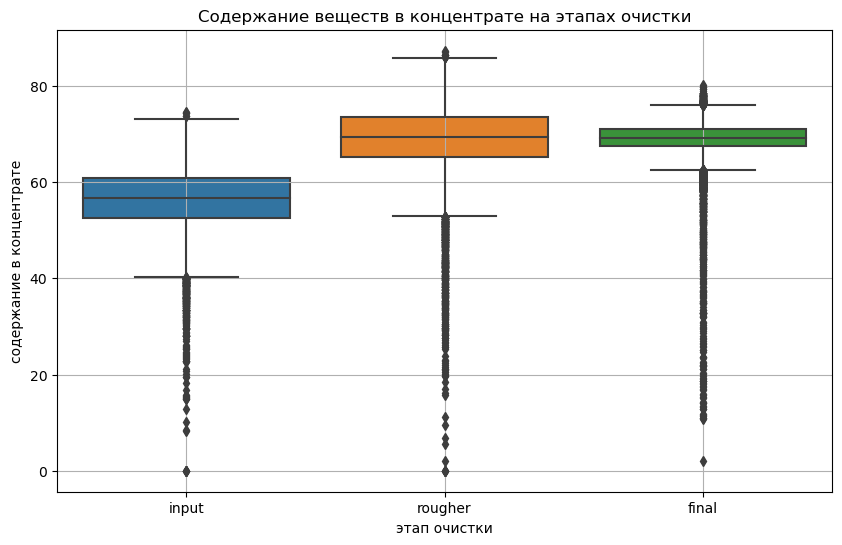

In [36]:
#сформируем сводную таблицу для построения боксплотов
concentration_sum = pd.DataFrame(columns=['concentration', 'stage'])
stage = ['input','rougher','final']
#добавляем данные
lst_col0 = list(train.columns)
for s in stage:
    if 'input' in s:
        lst_col1 = [item for item in lst_col0 if 'rougher.input.feed' in item]
        lst_col2 = [item for item in lst_col1 if ('rate' not in item)&('size' not in item)]
    else:
        lst_col1 = [item for item in lst_col0 if 'output.concentrate' in item]
        lst_col2 = [item for item in lst_col1 if s in item]
    #print(lst_col2)
    item_df = []
    item_df = pd.DataFrame(columns=['concentration','stage'])
    item_df['concentration'] = train[lst_col2].sum(axis=1)
    item_df['stage'] = item_df['stage'].fillna(s)
    concentration_sum = pd.concat([concentration_sum, item_df])  

fig, axs = plt.subplots(figsize=(10,6))

sns.boxplot(data=concentration_sum, x='stage', y='concentration',ax=axs)
axs.set(xlabel='этап очистки',
       ylabel='содержание в концентрате',      
       title='Содержание веществ в концентрате на этапах очистки'       
       )
axs.grid(True)
plt.show()

Как видно из графика доля концентрата не сильно изменяется в процессе очистки, наибольшая разница наблюдается между входным концентратом и концентратом после флотации (<10%), но как известно из уже построенных графиков состав концетрата меняется значительно - в нем становится намного больше золота и намного меньше sol.

## 4.4. <a id='toc4_4_'></a>[<font color='#42AAFF'>Выводы</font>](#toc0_)

1. Суммарная доля концентрата не сильно изменяется в процессе очистки, наибольшая разница наблюдается между входным концентратом и концентратом после флотации (<10%).
2. Доля золота (Au) в концентрате растёт равномерно по этапам очистки в среднем на 10-15%. При этом межквартильный размах доли золота довольно мал и не превышает 3-4%. Таким образом, эффект влияния очистки на долю золота в концетрате хорошо выражен. Доля золота в финальном концетрате в среднем достигает 45%.
3. Доля серебра (Ag) в концентрате ведёт себя немонотонно, но в финальном концетрате доля серебра ниже, чем в сырье. Доля свинца (Pb) в концентрате монотонно растёт, вероятно, исключительно за счёт уменьшения доли других компонентов. Доля sol в концентрате монотонно падает, наиболее сильно падение наблюдается после первичной очистки, вторичная очистка практически не изменяет содержание sol, но снижает разброс.
4. Распределения размеров гранул сырья для обучающей и тестовой выборок близки, что видно визуально и по основным количественным характеристикам распределений описательной статистики. Отметим, что распределения сильно скошены вправо (skewness>1) и имеют острые пики - значительно острее, чем в случае нормального распределения (kurtosis>0)

# 5. <a id='toc5_'></a>[<font color='#42AAFF'>Обучение моделей</font>](#toc0_)

## 5.1. <a id='toc5_1_'></a>[<font color='#42AAFF'>Функция для вычисления итоговой sMAPE</font>](#toc0_)

Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»). Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. Метрика sMAPE вычисляется так:

$sMAPE$ = $\frac{1}{N}\sum\limits _{i=1} ^{N}\frac{2|y_i - \hat{y_i}|}{|y_i|+|\hat{y_i}|}*100% $,\
где\
$y_i$ - значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество\
$\hat{y_i}$ - значение предсказания для объекта с порядковым номером i, например, в тестовой выборке\
$N$ - количество объектов в выборке


In [37]:
def smape(target , pred):
    smape = (2*np.abs(target - pred) / (np.abs(target) + np.abs(pred))).sum() / len(target) * 100
    return smape

Итоговая метрика учитывает качество оценки эффективности обогащения и чернового, и финального концентратов:

Итоговое sMAPE = $0.25*sMAPE(rougher) + 0.75*sMAPE(final)$

In [38]:
def complex_smape(target1, pred1, target2, pred2):       
    return 0.25 * smape(target1, pred1) + 0.75 * smape(target2, pred2)

## 5.2. <a id='toc5_2_'></a>[<font color='#42AAFF'>Подготовка выборок для обучения</font>](#toc0_)

Для прогноза каждой из искомых величин:
-	эффективность обогащения чернового концентрата `rougher.output.recovery`
-	эффективность обогащения финального концентрата `final.output.recovery`

будем использовать свою модель. 

Подготовим обучаюшую и тестовую выборку соответствующим образом.

Выборки для модели оценки обогащения чернового концентрата:

In [39]:
lst_features = [item for item in test.columns[1:] if 'rougher' in item]
lst_features.remove('rougher.output.recovery')
rougher_features_train = train[lst_features]
rougher_features_test = test[lst_features]
rougher_target_train = train['rougher.output.recovery']
rougher_target_test = test['rougher.output.recovery']

Выборки для модели оценки обогащения финального концентрата:

In [40]:
lst_features = list(test.columns)
for item in ['date','rougher.output.recovery','final.output.recovery']:
    lst_features.remove(item)
final_features_train = train[lst_features]
final_target_train = train['final.output.recovery']
final_features_test = test[lst_features]
final_target_test = test['final.output.recovery']

## 5.3. <a id='toc5_3_'></a>[<font color='#42AAFF'>Стандартизация признаков</font>](#toc0_)

Признаки имеют разные масштабы, приведем их к одному масштабу с помощью процедуры стандартизации. Обучим процедуру на тренировочной выборке и применим ее ко всем данным.

In [41]:
#отключаем вывод предупреждения SettingWithCopy
pd.options.mode.chained_assignment = None

scaler = StandardScaler()
scaler.fit(rougher_features_train)
rougher_features_train[rougher_features_train.columns] = scaler.transform(rougher_features_train)
rougher_features_test[rougher_features_test.columns] = scaler.transform(rougher_features_test)

scaler = StandardScaler()
scaler.fit(final_features_train)
final_features_train[final_features_train.columns] = scaler.transform(final_features_train)
final_features_test[final_features_test.columns] = scaler.transform(final_features_test)

## 5.4. <a id='toc5_4_'></a>[<font color='#42AAFF'>Исключение мультиколлинеарных признаков для оценки эффективности обогащения чернового концентрата</font>](#toc0_)

Подготовим функцию для определения VIF (Variance Inflation Factor):

In [42]:
def variance_inflation_factors(x):
    model = LinearRegression()
    vif = pd.DataFrame(columns=['features','vif'])
    for i in range(x.shape[1]):        
        x_i = x.drop(x.columns[i], axis=1)
        y_i = x[x.columns[i]]
        model_i = model.fit(x_i, y_i)
        y_i_pred = model_i.predict(x_i)        
        r2_i = r2_score(y_i, y_i_pred)        
        vif_i = 1 / (1 - r2_i)
        vif.loc[i,'features'] = x.columns[i]
        vif.loc[i,'vif'] = vif_i
        vif = vif.sort_values(by='vif',ascending=False).reset_index(drop=True)
    return vif

Вычислим VIF для исходного набора признаков:

In [43]:
variance_inflation_factors(rougher_features_train)

,features,vif
0,rougher.state.floatbank10_c_level,104.303807
1,rougher.state.floatbank10_e_level,70.278954
2,rougher.state.floatbank10_f_level,54.648013
3,rougher.state.floatbank10_d_level,48.525086
4,rougher.state.floatbank10_b_level,47.946487
5,rougher.state.floatbank10_d_air,15.253566
6,rougher.state.floatbank10_b_air,13.387746
7,rougher.input.floatbank10_xanthate,12.14926
8,rougher.state.floatbank10_e_air,12.047112
9,rougher.input.floatbank11_xanthate,11.590332


Как видно из таблицы более половины признаков имеют VIF>5, что указывает на наличие коллинеарных выбранному признаков в наборе. Будем итерационно убирать по одному признаку из исходного набора с наибольшим VIF, пересчитывая VIF на каждой итерации, до тех пор пока все VIF не окажутся < 5. Для этого напишем рекурсивную функцию.

In [44]:
def mc_exclude_iterative(x):
    vif = variance_inflation_factors(x)    
    if vif.loc[0,'vif']>5:              
        vif = mc_exclude_iterative(x.drop(vif.loc[0,'features'], axis=1))
    return vif

In [45]:
vif = mc_exclude_iterative(rougher_features_train)
vif

,features,vif
0,rougher.input.floatbank11_sulfate,4.815871
1,rougher.input.floatbank10_sulfate,4.336318
2,rougher.state.floatbank10_c_air,3.640535
3,rougher.input.feed_rate,3.26828
4,rougher.state.floatbank10_f_air,2.815784
5,rougher.state.floatbank10_a_level,2.622449
6,rougher.state.floatbank10_a_air,2.267567
7,rougher.input.feed_ag,2.064565
8,rougher.input.floatbank11_xanthate,2.055631
9,rougher.input.feed_sol,1.82195


Таким образом, сократили количество признаков с 22 до 13.

In [46]:
rougher_features_train = rougher_features_train[vif.features]
rougher_features_test = rougher_features_test[vif.features]

## 5.5. <a id='toc5_5_'></a>[<font color='#42AAFF'>Исключение мультиколлинеарных признаков для оценки эффективности обогащения финального концентрата</font>](#toc0_)

Вычислим VIF для исходного набора признаков:

In [47]:
variance_inflation_factors(final_features_train)

,features,vif
0,rougher.state.floatbank10_c_level,108.610994
1,rougher.state.floatbank10_e_level,72.999761
2,rougher.state.floatbank10_f_level,57.840366
3,rougher.state.floatbank10_b_level,52.492953
4,rougher.state.floatbank10_d_level,49.568223
5,primary_cleaner.state.floatbank8_b_level,32.190864
6,primary_cleaner.state.floatbank8_a_level,30.148
7,rougher.state.floatbank10_d_air,21.347845
8,secondary_cleaner.state.floatbank4_b_air,19.943111
9,primary_cleaner.state.floatbank8_c_level,18.295499


Как видно из таблицы более половины признаков имеют VIF>5, что указывает на наличие коллинеарных выбранному признаков в наборе. Будем итерационно убирать по одному признаку из исходного набора с наибольшим VIF, пересчитывая VIF на каждой итерации, до тех пор пока все VIF не окажутся < 5. 

In [48]:
vif = mc_exclude_iterative(final_features_train)
vif

,features,vif
0,secondary_cleaner.state.floatbank3_a_air,4.820758
1,rougher.state.floatbank10_a_level,4.574039
2,rougher.state.floatbank10_c_air,4.521696
3,secondary_cleaner.state.floatbank3_a_level,4.51103
4,secondary_cleaner.state.floatbank5_a_air,3.83116
5,rougher.state.floatbank10_f_air,3.5727
6,secondary_cleaner.state.floatbank2_a_air,3.548116
7,primary_cleaner.input.sulfate,3.536583
8,rougher.input.feed_rate,3.411032
9,secondary_cleaner.state.floatbank6_a_air,3.359937


Таким образом, сократили количество признаков с 52 до 31.

In [49]:
final_features_train = final_features_train[vif.features]
final_features_test = final_features_test[vif.features]

## 5.6. <a id='toc5_6_'></a>[<font color='#42AAFF'>Оптимизация модели для оценки эффективности обогащения чернового концентрата</font>](#toc0_)

Используя оценку RFE, исключим несущественные признаки по метрике SMAPE с применением кроссвалидации.

In [50]:
#задаем разбиения для кроссвалидации
folds = KFold(n_splits = 5, shuffle = True, random_state = 12345)
#задаем диапазон возможных значений числа признаков
hyper_params = [{'n_features_to_select': list(range(1, 14))}]
#определяем модель
model = LinearRegression()
model.fit(rougher_features_train, rougher_target_train)
rfe = RFE(model)  
#оптимизируем модель с помощью GridSearchCV по количеству отобранных признаков
model_cv = GridSearchCV(
    estimator = rfe, 
    param_grid = hyper_params, 
    scoring= make_scorer(smape,greater_is_better=False), 
    cv = folds, 
    verbose = 0,
    return_train_score=True)  
model_cv.fit(rougher_features_train, rougher_target_train)
cv_results = pd.DataFrame(model_cv.cv_results_)

Сформируем сводную таблицу для построения зависимости SMAPE на тренировочной и тестовой выборке при кроссвалидации от количества используемых в модели независимых признаков.

In [51]:
cols_test = list(cv_results.columns)[list(cv_results.columns).index('params')+1:list(cv_results.columns).index('mean_test_score')]
cols_train = list(cv_results.columns)[list(cv_results.columns).index('rank_test_score')+1:list(cv_results.columns).index('mean_train_score')]
pivot_df = pd.DataFrame(columns=['n_features','SMAPE','sample'])
pivot_df['n_features'] = list(cv_results['param_n_features_to_select'])*2*len(cols_test)
pivot_df['sample'] = (['train']*len(cv_results['param_n_features_to_select'])+['test']*len(cv_results['param_n_features_to_select']))*len(cols_test)
score = cv_results[cols_train[0]]
score = pd.concat([score, cv_results[cols_test[0]]],ignore_index=True)
for ind in range(1,len(cols_test)):
    score = pd.concat([score, cv_results[cols_train[ind]]],ignore_index=True)
    score = pd.concat([score, cv_results[cols_test[ind]]],ignore_index=True)    
pivot_df['SMAPE'] = abs(score)

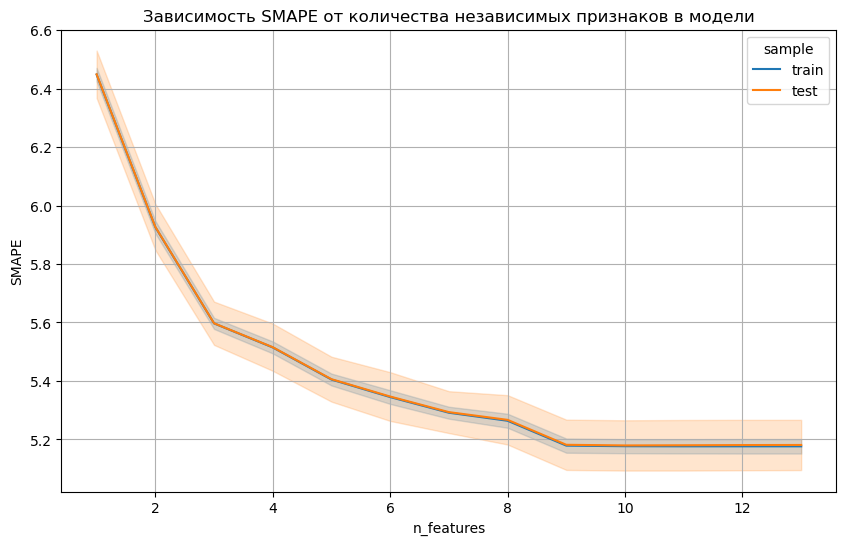

In [52]:
fig, axs = plt.subplots(figsize=(10,6))
sns.lineplot(data=pivot_df,x='n_features',y='SMAPE',hue='sample',ci='sd',ax=axs)
axs.grid(True)
axs.set(title='Зависимость SMAPE от количества независимых признаков в модели')
plt.show()

По графику можно сделать следующие выводы:
1. Наилучший SMAPE достигается при 9 признаках, при этом уже при 3 признаках отличие по средней метрике не превышает 0.5%.
2. Стандартное отклонение SMAPE на тестовых выборках кроссвалидации заметно подрастает после добавления 3го признака и с дальнейшим увеличением кол-ва признаков не уменьшается.
3. В целом SMAPE чуть больше 5% указывает на неплохую точность модели.

Таким образом, в качестве оптимальной модели можем выбрать модель с 3 признаками.

In [53]:
n_features_optimal = 3
rfe = RFE(model, n_features_to_select=n_features_optimal)   
rfe = rfe.fit(rougher_features_train, rougher_target_train)
rougher_model = rfe.estimator_
dump('rougher_model','rougher_model.joblib')

['rougher_model.joblib']

Определим коэффициенты регрессии:

In [54]:
rougher_coeff = pd.DataFrame(columns=['feature','coeff'])
rougher_coeff['feature'] = list(rfe.get_feature_names_out())
rougher_coeff['coeff'] = rougher_model.coef_
rougher_coeff

,feature,coeff
0,rougher.state.floatbank10_a_level,3.229150
1,rougher.input.feed_ag,2.987703
2,rougher.input.floatbank11_xanthate,2.014807


Рассмотрим взаимные зависимости выделенных факторов и целевого фактора:

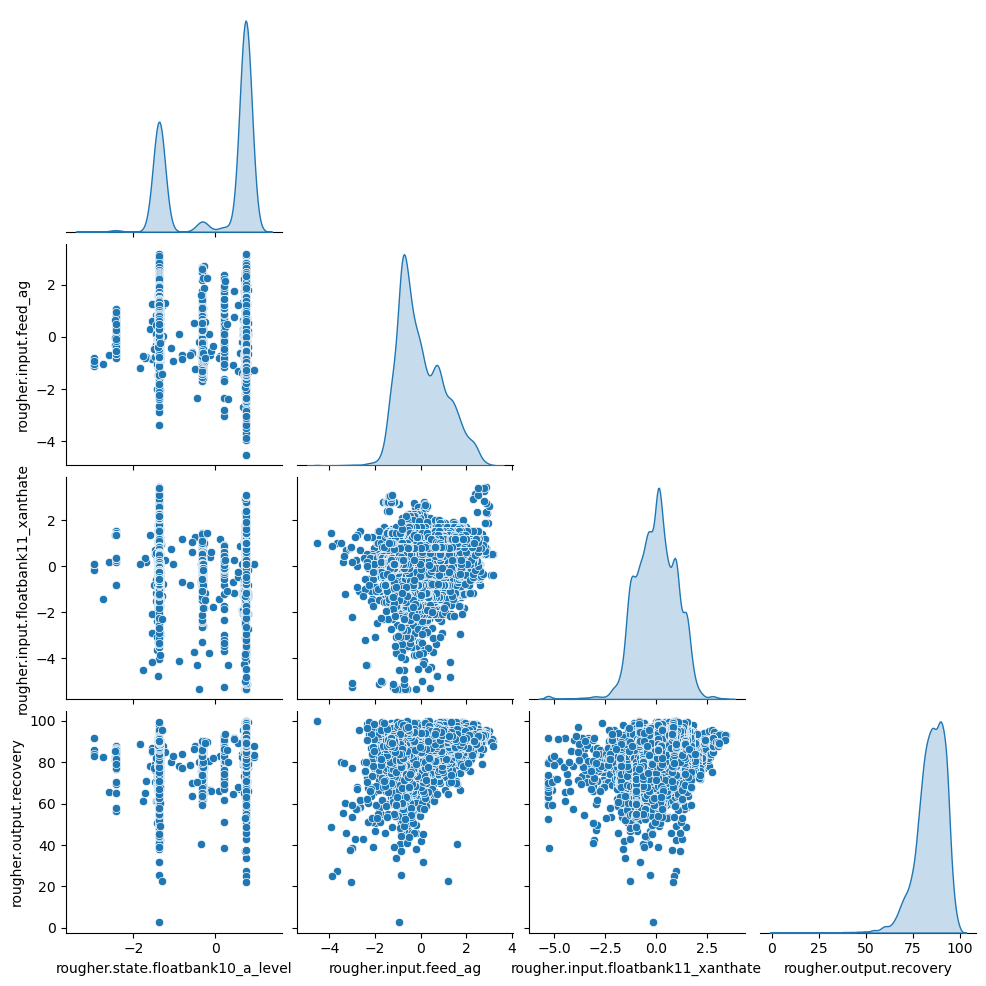

In [55]:
sns.pairplot(pd.concat([rougher_features_train[rougher_coeff['feature']],rougher_target_train],axis=1),corner=True, diag_kind='kde')
plt.show()

Возможно, качество модели можно еще несколько улучшить в случае грамотной обработки выбросов, которые мы видим на зависимостях целевого параметра от рассмотренных факторов.

## 5.7. <a id='toc5_7_'></a>[<font color='#42AAFF'>Оптимизация модели для оценки эффективности обогащения финального концентрата</font>](#toc0_)

Используя оценку RFE, исключим несущественные признаки по метрике SMAPE с применением кроссвалидации.

In [56]:
#задаем разбиения для кроссвалидации
folds = KFold(n_splits = 5, shuffle = True, random_state = 12345)
#задаем диапазон возможных значений числа признаков
hyper_params = [{'n_features_to_select': list(range(1, 32))}]
#определяем модель
model = LinearRegression()
model.fit(final_features_train, final_target_train)
rfe = RFE(model)  
#оптимизируем модель с помощью GridSearchCV по количеству отобранных признаков
model_cv = GridSearchCV(
    estimator = rfe, 
    param_grid = hyper_params, 
    scoring= make_scorer(smape,greater_is_better=False), 
    cv = folds, 
    verbose = 0,
    return_train_score=True)  
model_cv.fit(final_features_train, final_target_train)
cv_results = pd.DataFrame(model_cv.cv_results_)

Сформируем сводную таблицу для построения зависимости SMAPE на тренировочной и тестовой выборке при кроссвалидации от количества используемых в модели независимых признаков.

In [57]:
cols_test = list(cv_results.columns)[list(cv_results.columns).index('params')+1:list(cv_results.columns).index('mean_test_score')]
cols_train = list(cv_results.columns)[list(cv_results.columns).index('rank_test_score')+1:list(cv_results.columns).index('mean_train_score')]
pivot_df = pd.DataFrame(columns=['n_features','SMAPE','sample'])
pivot_df['n_features'] = list(cv_results['param_n_features_to_select'])*2*len(cols_test)
pivot_df['sample'] = (['train']*len(cv_results['param_n_features_to_select'])+['test']*len(cv_results['param_n_features_to_select']))*len(cols_test)
score = cv_results[cols_train[0]]
score = pd.concat([score, cv_results[cols_test[0]]],ignore_index=True)
for ind in range(1,len(cols_test)):
    score = pd.concat([score, cv_results[cols_train[ind]]],ignore_index=True)
    score = pd.concat([score, cv_results[cols_test[ind]]],ignore_index=True)    
pivot_df['SMAPE'] = abs(score)

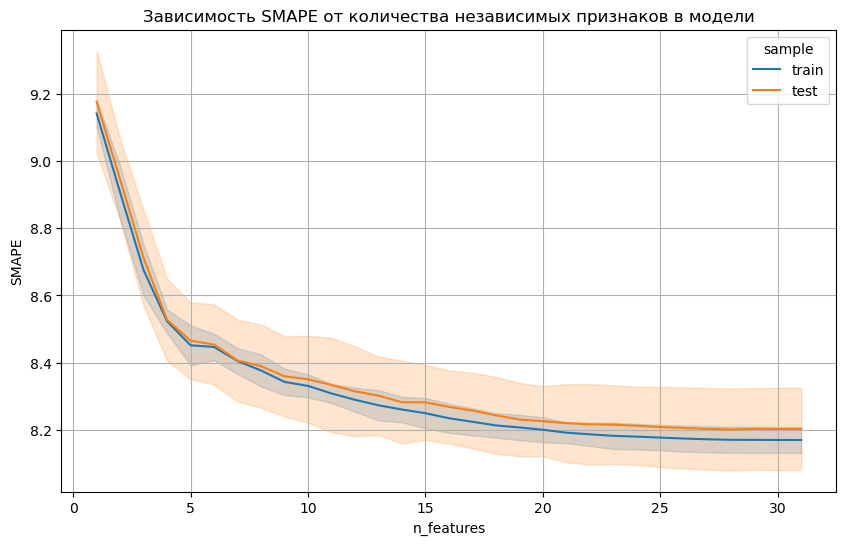

In [58]:
fig, axs = plt.subplots(figsize=(10,6))
sns.lineplot(data=pivot_df,x='n_features',y='SMAPE',hue='sample',ci='sd',ax=axs)
#axs.set(xlim=(350,450)) 
axs.grid(True)
axs.set(title='Зависимость SMAPE от количества независимых признаков в модели')
plt.show()

По графику можно сделать следующие выводы:
1. SMAPE монотонно уменьшается по мере увеличение числа признаков, при этом наиболее существенное изменение происходит при увеличении с 1 до 5 признаков - на ~0.7%, при увеличении с 5 до 31 признака SMAPE изменяется меньше - всего на ~0.3%.
2. Стандартное отклонение SMAPE на тестовых выборках кроссвалидации заметно подрастает после добавления 5го признака и с дальнейшим увеличением кол-ва признаков не уменьшается.
3. В целом SMAPE составляет 8-9%, что несколько больше, чем для модели оценки эффективности обогащения чернового концентрата, что вполне логично.

Для определенности выберем модель с 5 признаками.

In [59]:
n_features_optimal = 5
rfe = RFE(model, n_features_to_select=n_features_optimal)   
rfe = rfe.fit(final_features_train, final_target_train)
final_model = rfe.estimator_
dump('final_model','final_model.joblib')

['final_model.joblib']

In [60]:
final_coeff = pd.DataFrame(columns=['feature','coeff'])
final_coeff['feature'] = list(rfe.get_feature_names_out())
final_coeff['coeff'] = final_model.coef_
final_coeff

,feature,coeff
0,secondary_cleaner.state.floatbank3_a_air,2.500337
1,primary_cleaner.input.sulfate,1.695504
2,secondary_cleaner.state.floatbank3_b_air,-1.145989
3,rougher.input.feed_ag,1.681892
4,rougher.input.floatbank11_xanthate,2.101587


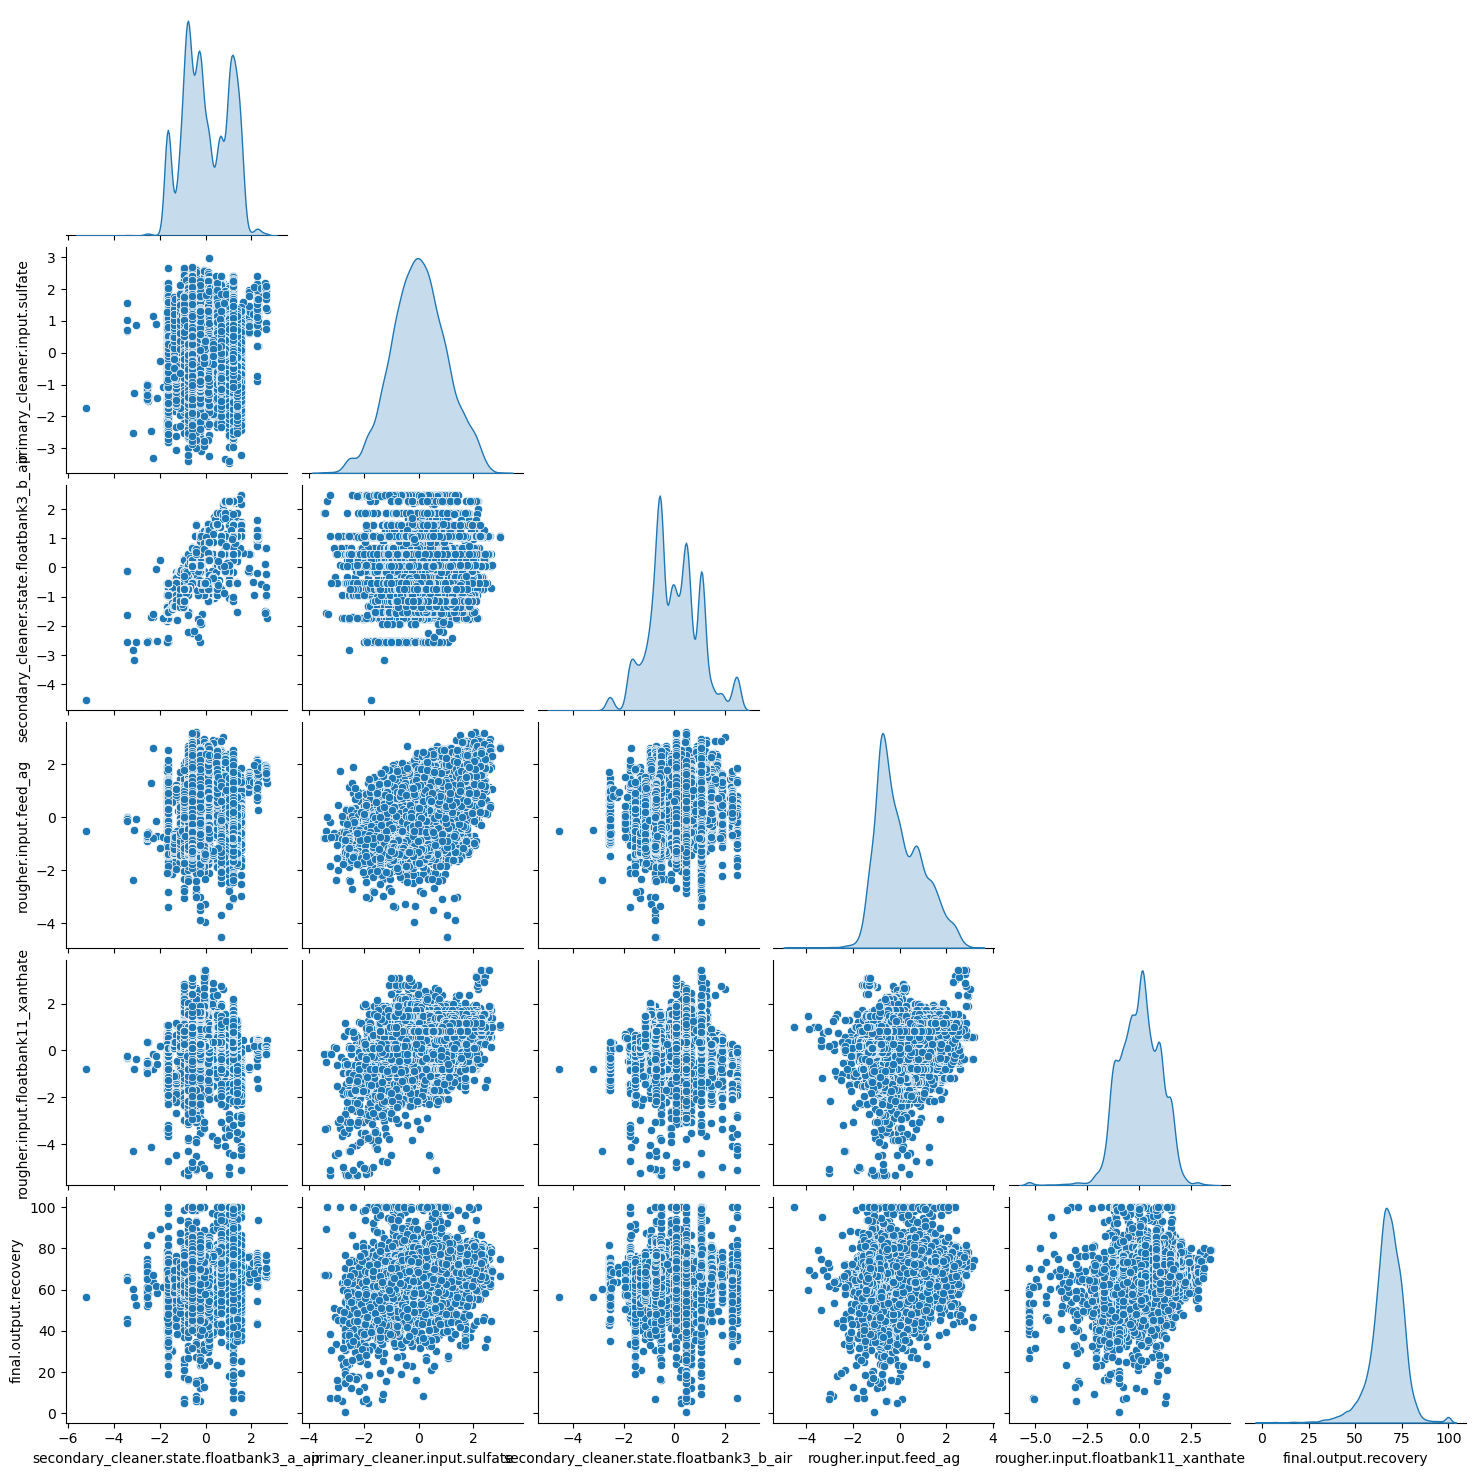

In [61]:
sns.pairplot(pd.concat([final_features_train[final_coeff['feature']],final_target_train],axis=1),corner=True, diag_kind='kde')
plt.show()

Возможно, качество модели можно еще несколько улучшить в случае грамотной обработки выбросов, которые мы видим на зависимостях целевого параметра от рассмотренных факторов.

## 5.8. <a id='toc5_8_'></a>[<font color='#42AAFF'>Выводы</font>](#toc0_)

1. Подготовили функцию для вычисления итоговой SMAPE.
2. Подготовили выборки для обучения, стандартизировали признаки.
3. Исключили мультиколлинеарные признаки по критерию VIF>5, что повзолило сократить их число до 13 и 31 в случае модели для оценки эффективности обогащения на черновом и финальном этапах соответственно.
4. Применяя рекурсивные расчеты с различным числом признаков на кроссвалидации, определили зависимости SMAPE для тренировочных и тестовых выборках от количества признаков. Выяивили наиболее значимые признаки и обучили модели: 
     - 3 признака для модели оценки эффективности обогащения чернового концентрата при SMAPE 5.6%
     - 5 признаков для модели оценки эффективности обогащения финального концентрата при SMAPE 8.5%
5. Определили коэффициенты линейных регрессий для финальных моделей.

# 6. <a id='toc6_'></a>[<font color='#42AAFF'>Результаты оценок моделей на тестовой выборке</font>](#toc0_)

Рассчитаем SMAPE на тестовой выборке для оценки эффективности обогащения чернового концентрата:

In [62]:
pred_rougher = rougher_model.predict(rougher_features_test[rougher_coeff['feature']].values)
print(f'SMAPE оценки эффективности обогащения чернового концентрата {smape(rougher_target_test, pred_rougher):0.1f}%')

SMAPE оценки эффективности обогащения чернового концентрата 8.2%


In [63]:
pred_final = final_model.predict(final_features_test[final_coeff['feature']].values)
print(f'SMAPE оценки эффективности обогащения финального концентрата {smape(final_target_test, pred_final):0.1f}%')

SMAPE оценки эффективности обогащения финального концентрата 8.8%


In [64]:
print(f'Итоговое SMAPE {complex_smape(rougher_target_test, pred_rougher, final_target_test, pred_final):0.1f}%')

Итоговое SMAPE 8.6%


# 7. <a id='toc7_'></a>[<font color='#42AAFF'>Общие выводы</font>](#toc0_)

I. Подготовка данных.

1. Проверили правильность расчёта эффективности обогащения на обучающей выборке по имеющимся данным, получили MAE 1e-14, таким образом расчёты выполнены корректно.
2. Сравнили столбцы в обучающей и тестовой выборках, в тестовой выборке отсутствуют расчётные признаки (calculation) и характеристики продукта (output), включае данные по концентрату и хвостам.  
3. Явных дубликатов в данных не обнаружили.
4. В тестовой выборке доля пропусков невелика (90), поэтому строки с ними просто удалили.
5. В тренировочной выборке количество пропусков велико - 4100, при этом в необходимых для обучения признаках ~ 1700. Так как процесс очистки во времени непрерывный, то соседние по времени точки близки по своим значениям. Для заполнения пропусков в признаках, необходимых для обучения, применили аппроксимирующий сплайн.
6. В целевых показателях тренировочной выборки убрали выбросы равные 0.

II. Исследование данных.

1. Суммарная доля концентрата не сильно изменяется в процессе очистки, наибольшая разница наблюдается между входным концентратом и концентратом после флотации (<10%).
2. Доля золота (Au) в концентрате растёт равномерно по этапам очистки в среднем на 10-15%. При этом межквартильный размах доли золота довольно мал и не превышает 3-4%. Таким образом, эффект влияния очистки на долю золота в концетрате хорошо выражен. Доля золота в финальном концетрате в среднем достигает 45%.
3. Доля серебра (Ag) в концентрате ведёт себя немонотонно, но в финальном концетрате доля серебра ниже, чем в сырье. Доля свинца (Pb) в концентрате монотонно растёт, вероятно, исключительно за счёт уменьшения доли других компонентов. Доля sol в концентрате монотонно падает, наиболее сильно падение наблюдается после первичной очистки, вторичная очистка практически не изменяет содержание sol, но снижает разброс.
4. Распределения размеров гранул сырья для обучающей и тестовой выборок близки, что видно визуально и по основным количественным характеристикам распределений описательной статистики. Отметим, что распределения сильно скошены вправо (skewness>1) и имеют острые пики - значительно острее, чем в случае нормального распределения (kurtosis>0).

III. Обучение, оптимизация и проверка моделей.

1. Подготовили функцию для вычисления итоговой SMAPE.
2. Подготовили выборки для обучения, стандартизировали признаки.
3. Исключили мультиколлинеарные признаки по критерию VIF>5, что повзолило сократить их число до 13 и 31 в случае модели для оценки эффективности обогащения на черновом и финальном этапах соответственно.
4. Применяя рекурсивные расчеты с различным числом признаков на кроссвалидации, определили зависимости SMAPE для тренировочных и тестовых выборках от количества признаков. Выяивили наиболее значимые признаки и обучили модели: 
     - 3 признака для модели оценки эффективности обогащения чернового концентрата при SMAPE 5.6%
     - 5 признаков для модели оценки эффективности обогащения финального концентрата при SMAPE 8.5%
5. Определили коэффициенты линейных регрессий для финальных моделей.
6. Проверили модели на тестовой выборке и получили SMAPE оценки эффективности обогащения в черновом и финальном концентратах 8.2% и 8.8% соответственно, а для комплексного SMAPE - 8.6%.